# Sequential Model Validations

## Input Types
These validation functions want inputs of nested dictionaries with spotID keys, and `predictions`, `labels`, `lola`, and `timestamps` keys. For example:
```python
input = {'5d703b2ae4a3a8000133196a': {['predictions':array, 'labels':array, 'timestamps':array, 'lola':array]}, ...}
```
Mine actually have `predictions_min`, `lola_min`, etc for `min` and `max`.

Overall MSE probably isn't a good indicator of how the models perform, since this is essentially an anomoly detection problem. This is a place to explore more validation metrics, per spot or not.

In [79]:
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import matplotlib
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.backends.backend_pdf
#from matplotlib import rc
#rc('text', usetex=True)  # docker doesn't have latex installed

from collections import defaultdict
from scipy.stats import sigmaclip
from mlsurfzone import validate
from ipdb import set_trace

np.set_printoptions(precision=3)

In [2]:
base_dir = os.environ['MLSURFZONE_DATA_DIR']

In [3]:
# Load the inference pickle.
pkl_name = 'van_per_spot.pkl'

with open(os.path.join(base_dir, pkl_name),'rb') as f:
    dat = pickle.load(f)
    
# Load SpotID <-> alias map - only readable in python 3.7!
with open('alias_spotid_map.pkl', 'rb') as f:
    alias_map = pickle.load(f)
id_map = {v:k for k, v in alias_map.items()}

In [15]:
def get_time_chunks(timestamps, delta=1, return_indices=False):
    """ 
    Given a list of sorted times, find where they're sequential 
    within some time delta in days. Return chunked list.
    """
    dt_days = [dt.total_seconds()/3600/24 for dt in np.diff(timestamps)]
    dt_days = np.hstack(([0], dt_days)) # Shift to get indices corresponding to input
    chunks = (np.where(dt_days > delta)[0]).astype(int)
    if len(chunks) == 0:
        return [0] if return_indices else [timestamps]
    
    # Shift again since we always want to start at the beginning
    chunks = np.hstack(([0], chunks))
    
    if return_indices:    
        return chunks
    
    return [timestamps[chunks[i]: chunks[i+1]] for i in range(len(chunks) - 1)]


In [16]:
chunks = get_time_chunks(dat['5842041f4e65fad6a770883b']['timestamps'])

In [17]:
chunks[:3]

[array([datetime.datetime(2016, 11, 5, 7, 0),
        datetime.datetime(2016, 11, 5, 12, 0),
        datetime.datetime(2016, 11, 6, 8, 0),
        datetime.datetime(2016, 11, 6, 14, 0)], dtype=object),
 array([datetime.datetime(2016, 12, 5, 7, 0),
        datetime.datetime(2016, 12, 5, 12, 0),
        datetime.datetime(2016, 12, 6, 7, 0),
        datetime.datetime(2016, 12, 6, 16, 0),
        datetime.datetime(2016, 12, 7, 7, 0),
        datetime.datetime(2016, 12, 7, 14, 0),
        datetime.datetime(2016, 12, 8, 7, 0),
        datetime.datetime(2016, 12, 8, 13, 0),
        datetime.datetime(2016, 12, 9, 7, 0),
        datetime.datetime(2016, 12, 9, 14, 0),
        datetime.datetime(2016, 12, 10, 7, 0),
        datetime.datetime(2016, 12, 10, 13, 0),
        datetime.datetime(2016, 12, 11, 7, 0),
        datetime.datetime(2016, 12, 11, 14, 0)], dtype=object),
 array([datetime.datetime(2017, 1, 2, 7, 0),
        datetime.datetime(2017, 1, 3, 7, 0),
        datetime.datetime(2017, 1, 3,

In [4]:
def get_spot_df(dat, spotid):
    """ 
    I want each spot partitioned by chunks of sequential samples in time.
    Make a dataframe for some specific spot and 
    add a 'chunk' column which denotes these groupings.   
    """
    df = pd.DataFrame(dat[spotid])

    # Make chunk array
    chunk_idxs = get_time_chunks(dat[spotid]['timestamps'], return_indices=True)
    chunk_arr = np.zeros(len(df), dtype=int)
    if len(chunk_idxs) > 1:
        for i in range(len(chunk_idxs) - 1):
            chunk_arr[chunk_idxs[i]: chunk_idxs[i+1]] = i
        chunk_arr[chunk_idxs[-1]:] = i+1

    df['chunks'] = chunk_arr
    
    # Convert ns -> hours unit in np datetimes. Doesn't matter, pandas forces ns units.
    df['timestamps'] = df['timestamps'].astype('datetime64[h]')
    
    df = df.fillna(-.5)
    
    return df

In [19]:
# Seaborn wants dataframes for plots. Make a dataframe for each spot, with a 'chunk' col.
spotid = '5842041f4e65fad6a770883b'
df = get_spot_df(dat, spotid)
df


predictions  labels          timestamps      lola  lotus  chunks
0       4.331311     6.0 2016-11-05 07:00:00  8.367857    2.1       0
1       4.047992     7.0 2016-11-05 12:00:00  8.097926    2.0       0
2       3.892643     5.0 2016-11-06 08:00:00  6.138428    1.8       0
3       4.114080     7.0 2016-11-06 14:00:00  6.038454    1.6       0
4       4.312246     4.0 2016-12-05 07:00:00  3.599078    1.0       1
..           ...     ...                 ...       ...    ...     ...
172     3.447229     3.0 2019-09-20 20:00:00 -1.640000    0.8      11
173     4.060187     3.0 2019-09-21 14:00:00  3.379135    1.0      11
174     3.379166     3.0 2019-09-21 21:00:00  3.349142    0.8      11
175     3.372638     3.0 2019-09-22 14:00:00  3.409127    1.1      11
176     3.377121     4.0 2019-09-22 20:00:00  3.479109    1.1      11

[177 rows x 6 columns]

In [20]:
def chunk_plots(df, title=None, return_fig=False):
    """ Apparently seaborn is the worst way to do this. I can't get 
    a legend to work
    """
    # Plot raw predictions
    g = sns.FacetGrid(df, col="chunks", col_wrap=3, 
                      sharex=False, sharey=False)#, aspect=1.2)
    
    g.map(sns.pointplot, "timestamps", "labels", color='m')
    g.map(sns.pointplot, "timestamps", 'predictions', color='blue')
    g.map(sns.pointplot, 'timestamps', 'lola', color='green')

    g.set_xticklabels([])
    g.fig.tight_layout()

    # Change the 'chunk = ?' titles to date
    axes = g.axes.flatten()
    dates = [t[1]['timestamps'].iloc[-1] for t in df.groupby('chunks')]
    for ax, date in zip(axes, dates): ax.set_title(date)
    
    # Change xlabels and ylabels
    g.set_axis_labels(" ", "feet");

    # Set title of this spot
    if title is not None:
        g.fig.subplots_adjust(top=0.88)
        plt.suptitle(title, size=18)
        
    if return_fig:
        return g.fig
    else:
        plt.show()

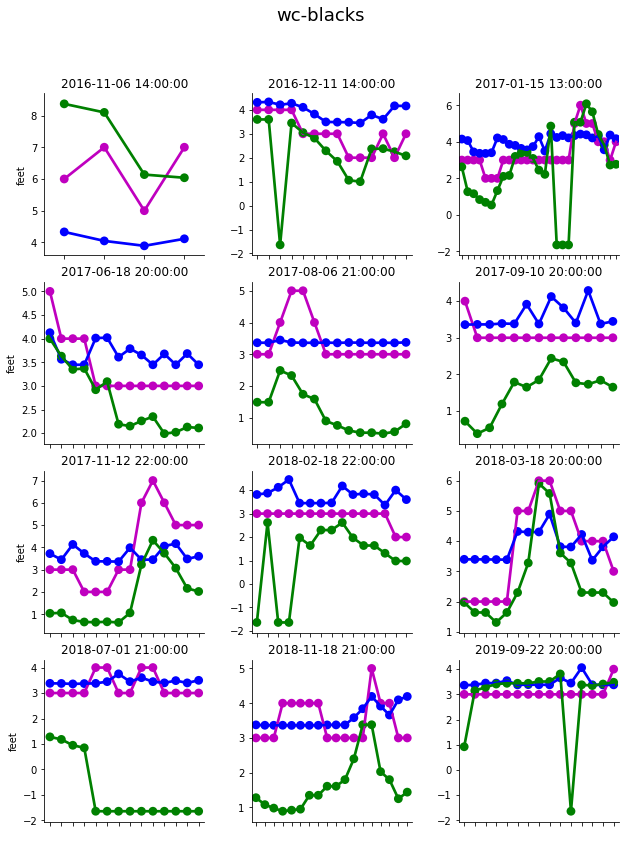

In [21]:
#df['labels_max'] = df['labels_max'] * np.random.normal(loc=1, scale=0.05, size=len(df))
chunk_plots(df, title=id_map[spotid])

In [11]:
df['labels'] = df['labels'] * np.random.normal(loc=1, scale=0.05, size=len(df))
chunk_plots(df, title=id_map[spotid])

In [22]:
def make_chunks_pdf(dat, save_name='spot_chunks.pdf'):
    """ Make a pdf where each page is all the plots for a spot """
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_name)

    # Make it alphabetized by spot name
    spotids = list(dat.keys())
    aliases = [(id_map[spotid] if spotid in id_map.keys() else spotid) 
               for spotid in dat.keys()]
    for idx in np.argsort(aliases):
        df = get_spot_df(dat, spotids[idx])
        fig = chunk_plots(df, title=aliases[idx], return_fig=True)
        
        pdf.savefig(fig)
        plt.close()
    pdf.close()
    
    print(f'Wrote {save_name}')
        

In [25]:
make_chunks_pdf(dat)

Wrote spot_chunks.pdf


In [5]:
def mae(x, y):
    return np.nanmean(np.abs(x-y))

In [14]:
def get_covariance(x, y, rot=-45):
    """ 
    Look at the covariance spread about two variables.
    If y=x or y should equal x, and you know the 
    rotation angle of that line, you can rotate those
    vectors and look at the variance about the vertical
    only, by setting the appropriate roatation angle
    as `rot`.
    """
    x, y = np.array(x[~np.isnan(y)]), np.array(y[~np.isnan(y)])
    if rot != 0:
        theta = np.deg2rad(rot)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))
        x_, y_ = np.dot(R, np.vstack((x, y)))
        
        # Take the y-component from the covariance matrix only.
        # The x-component should be large if x=y, and y should be ~zero
        cov = np.cov(x_, y_)
        sig_xy = cov[-1][-1]
    else:
        cov = np.cov(x, y)
        sig_xy = np.linalg.det(cov)
        
    return x, y, sig_xy

In [122]:
def count_outliers(x, sigma=2):
    """ Count and normalize the number of statistical outliers """
    c, low, upp = sigmaclip(x, low=sigma, high=sigma)
    return 1 - (len(c) / len(x))

In [123]:
def make_hex_plots(dat, save_name, show=False):
    """ 
    More pdfs - now just plot the error at each spot. 
    Similar to multiplots per page as above, but one spot
    per plot rather than one page per spot. Don't necessarily
    care about sequences here. Let's do some raw matplotlib
    so we can change plotting attributes more easily!
    """
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_name)

    # Make it alphabetized by spot name
    spotids = list(dat.keys())
    aliases = [(id_map[spotid] if spotid in id_map.keys() else spotid) 
               for spotid in dat.keys()]
    idxs = np.argsort(aliases).astype(int)
    spotids_gen = (spotids[idx] for idx in idxs)
    aliases_gen = (aliases[idx] for idx in idxs)

    Nsample = len(dat)
    print(f'Making {Nsample} plots...')
    enum = 3 # plots per page
    gt4 = []
    for i in range(0, Nsample, enum):#Nsample, enum):
        fig, axs = plt.subplots(3, 3, figsize=(8.5, 8), sharey=True)
        fig.subplots_adjust(top=0.85)#, hspace=.5, wspace=.3)
        #axs = axs.ravel()
        for j in range(enum):  # one plot for each net, lola, lotus
            try:
                alias = next(aliases_gen)
                idat = dat[next(spotids_gen)]
                # Keep track of errors for additional histograms
            except:
                plt.tight_layout()

            net_err = mae(idat['labels'], idat['predictions'])
            lola_err = mae(idat['labels'], idat['lola'])
            lotus_err = mae(idat['labels'], idat['lotus'])
            
            # Compute the deltas?
            net = idat['predictions']
            lola = idat['lola']
            lotus = idat['lotus']
            labels = idat['labels']

            cat = np.hstack((net, lola, lotus))
            cat = cat[~np.isnan(cat)]
            max, min = np.max(cat), np.min(cat)
            if max < min: max, min = min, max
            
            x, y, sig_model = get_covariance(labels, net)
            out_model = count_outliers(x-y)
            axs[j][0].hexbin(x, y,
                             color='#0058B0', label='Net', 
                             gridsize=(int(max/1.1), int(max/1.1)), cmap='Blues',
                             mincnt=1)
            axs[j][0].set_ylim([0, np.max(cat)])
            
            x, y, sig_lola = get_covariance(labels, lola)
            out_lola = count_outliers(x-y)
            axs[j][1].hexbin(x, y,
                              color='#0058B0', label='Lola', 
                              gridsize=(int(max/1.1), int(max/1.1)), cmap='Blues',
                              mincnt=1)
            
            x, y, sig_lotus = get_covariance(labels, lotus)
            out_lotus = count_outliers(x-y)
            axs[j][2].hexbin(x, y,
                          color='#0058B0', label='Lotus', 
                          gridsize=(int(max/1.1), int(max/1.1)), cmap='Blues',
                          mincnt=1)
            
            zipper = zip(['Model', 'Lola', 'Lotus'], 
                         [net_err, lola_err, lotus_err],
                         [sig_model, sig_lola, sig_lotus],
                         [out_model, out_lola, out_lotus])
            
            for col, (title, err, sig, out) in enumerate(zipper):
                axs[j][col].annotate(title, xy=(0.05,0.9),xycoords='axes fraction',
                                    fontsize=13)
                axs[j][col].annotate(f'MAE={err:.2f}', xy=(0.05, 0.83), 
                                     xycoords='axes fraction',
                                     fontsize=10)
                axs[j][col].annotate(f'sig={sig:.2f}', xy=(0.05, 0.76), 
                                     xycoords='axes fraction',
                                     fontsize=10)
                axs[j][col].annotate(f'out={out:.2f}', xy=(0.05, 0.69), 
                                     xycoords='axes fraction',
                                     fontsize=10)

            xx = np.arange(0, np.max(cat)+5)
            for col in range(3):
                #pass
                axs[j][col].plot(xx, xx,'--', color='#333333', alpha=0.4)
                #axs[j][col].legend(loc=2)
                axs[j][col].set_xlim([0, max])
                #axs[j][col].set_ylim([0, max])
            
            axs[j][1].set_title(alias, fontsize=13)
            
            axs[j][0].set_xlabel('Label (ft)', fontsize=10)
            axs[j][0].set_ylabel('Model (ft)', fontsize=10)

            if net_err >= 4:
                print('{0}, {1:.1f}, {2:.1f}, {3:.1f}'.format(
                alias, net_err, lola_err, lotus_err))
                gt4.append('{0}, {1:.1f}, {2:.1f}, {3:.1f}\n'.format(
                alias, net_err, lola_err, lotus_err))
                
            #axs[j][0].set_ylim([0, max])

        plt.tight_layout()
        plt.subplots_adjust(wspace=0)
        #for _ in range(3): axs[j][_].set_ylim([0, np.max(cat)])
        
        pdf.savefig(fig)
        if show: 
            plt.show()
            break
        else:
            plt.close()
            
    if show:
        return
    
    pdf.close()
    #gt4.close()
    print('Wrote {}'.format(save_name))
    print('Large errors:')
    print(gt4)

Making 245 plots...


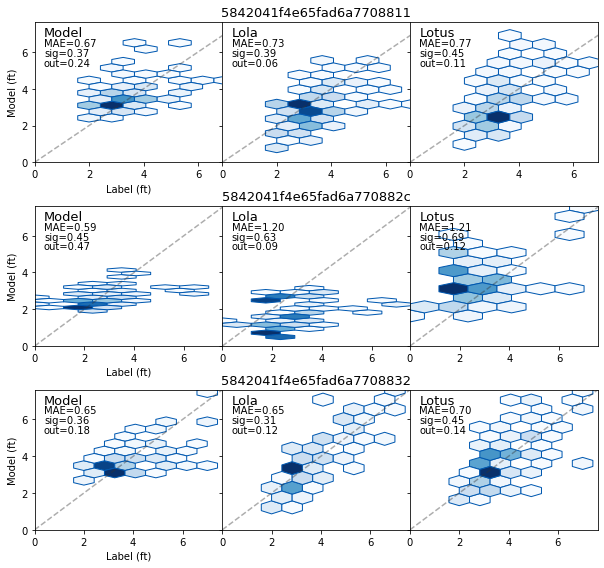

In [124]:
make_hex_plots(dat, 'spot_hex.pdf', show=True)

In [125]:
make_hex_plots(dat, 'spot_hex.pdf')

Making 245 plots...
wc-wedge, 6.9, 1.2, 2.4
Wrote spot_hex.pdf
Large errors:
['wc-wedge, 6.9, 1.2, 2.4\n']


In [37]:
# print errors for and all spots
preds = np.hstack([dat[spot]['predictions'] for spot in dat.keys()])
labels = np.hstack([dat[spot]['labels'] for spot in dat.keys()])
lola = np.hstack([dat[spot]['lola'] for spot in dat.keys()])
lotus = np.hstack([dat[spot]['lotus'] for spot in dat.keys()])

lola_mae = mae(lola, labels)
lotus_mae = mae(lotus, labels)
preds_mae = mae(preds, labels)

print(f'LOLA-LABELS MAE: {lola_mae:.4f}')
print(f'LOTUS-LABELS MAE: {lotus_mae:.4f}')
print(f'NET-LABELS MAE: {preds_mae:.4f}')


LOLA-LABELS MAE: 0.9635
LOTUS-LABELS MAE: 1.1887
NET-LABELS MAE: 0.8921


In [64]:
# Histogram of errors per spot
def hist_mae(dat, bins=50, normed=False):
    err = defaultdict(list)
    for v in dat.values():
        err['net'].append(mae(v['labels'], v['predictions']))
        err['lola'].append(mae(v['labels'], v['lola']))
        err['lotus'].append(mae(v['labels'], v['lotus']))

    plt.figure(figsize=(10, 6))
    Nnet, net_bin_edges, _ = plt.hist(err['net'], bins=bins, normed=normed,
                 color='b', label='Model', alpha=.7,ec='black')
    Nlola, lola_bin_edges, _ = plt.hist(err['lola'], bins=bins, normed=normed,
                 color='r', label='LOLA', alpha=0.5,ec='black')
    Nlotus, lola_bin_edges, _ = plt.hist(err['lola'], bins=bins, normed=normed,
                 color='m', label='Lotus', alpha=0.1, ec='black')
    plt.legend()
    plt.show()

In [65]:
hist_mae(dat)

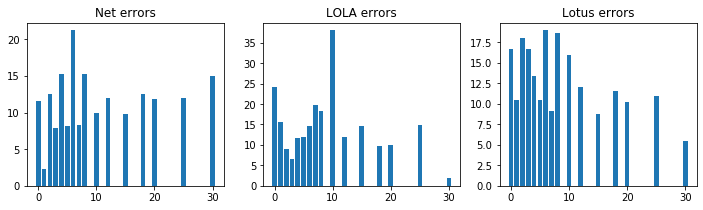

In [68]:
# figure of errors as a function of wave heights
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(131)
ax.bar(labels, np.abs(labels - preds))
ax.set_title('Net errors')
ax = fig.add_subplot(132)
ax.bar(labels, np.abs(labels - lola))
ax.set_title('LOLA errors')
#ax.set_xtitle('feet')
ax = fig.add_subplot(133)
ax.bar(labels, np.abs(labels - lotus))
ax.set_title('Lotus errors')
plt.show()